# Re-gridding vs. re-projection

We demonstrate the gridding of fields with `cygrid`, using HI data from EBHIS and far-infrared data from Planck. In this example, we grid one image onto another

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`wcsaxes`](http://wcsaxes.readthedocs.org) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.utils.data import conf
from astropy.wcs import WCS
from astroquery.skyview import SkyView

import cygrid


# We'll be loading some data from skyview, hence the longer timeout
conf.remote_timeout = 60.

We change the `matplotlib` settings to improve and standardise our plots.

In [3]:
params = {
    'backend': 'pdf',
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.family': 'serif',
    'figure.dpi': 75
}

rcParams.update(params)

Let's furthermore define some plotting `kwargs` for the images.

In [4]:
imkw = dict(
    origin='lower', interpolation='nearest',
    )

For this demonstration, we show how to grid data from a large fits-file onto another one with a different extent and coordinate system.
First, we need to obtain our input image. We use `skyview` to get an image of Planck 857 GHz data in galactic coordinates.

In [5]:
paths = SkyView().get_images(
    position='177., 61.',
    coordinates='J2000',
    pixels='500',
    scaling='Linear',
    survey=['Planck 857 I'],
    )

In [6]:
input_header, input_data = paths[0][0].header, paths[0][0].data

Here's how our input datalook like:

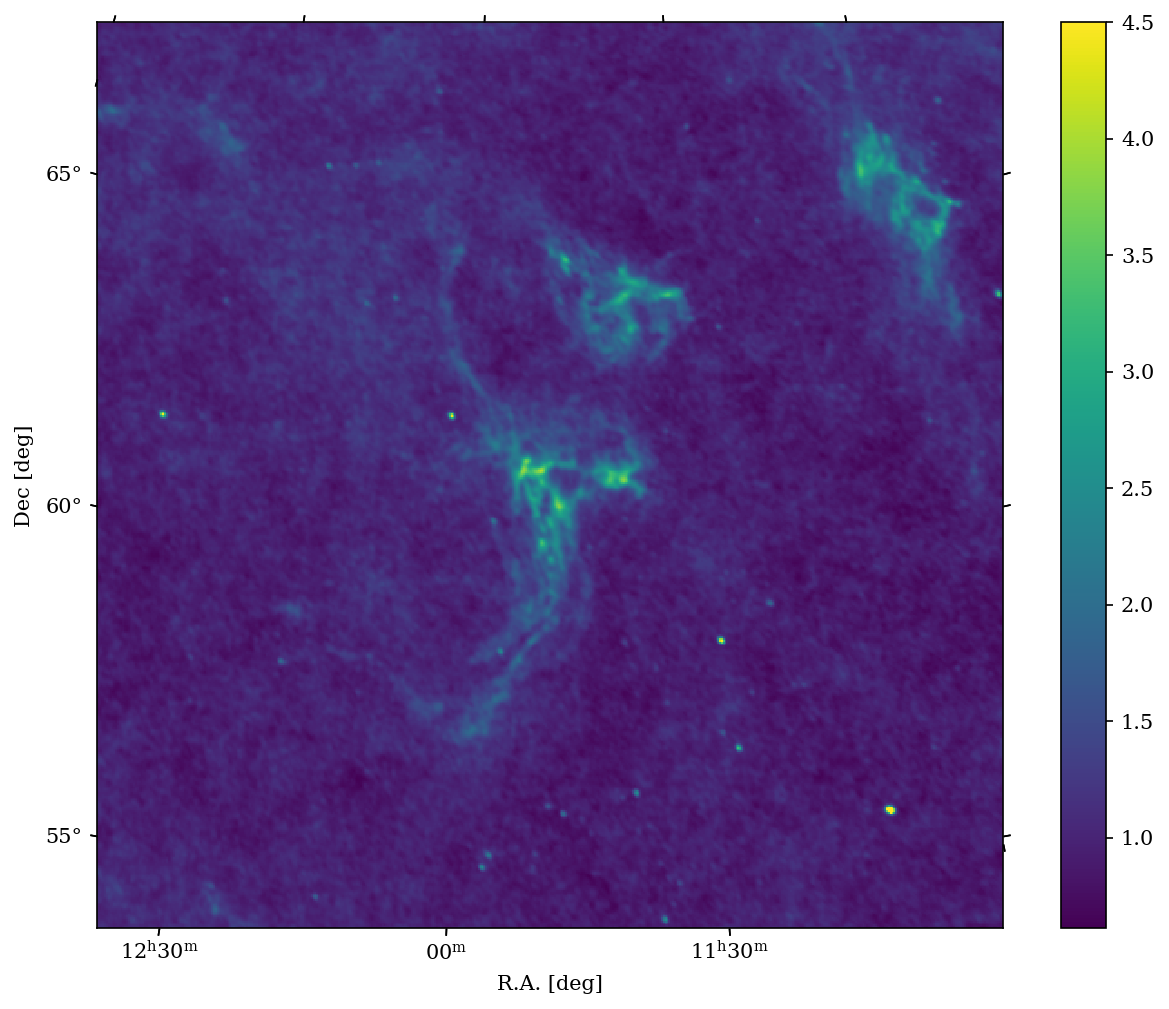

In [7]:
input_wcs = WCS(input_header)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=input_wcs)
lon, lat = ax.coords
im = ax.imshow(input_data, vmax=4.5, cmap='viridis', **imkw)
plt.colorbar(im, ax=ax)
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')

We download the EBHIS HI data onto which we will grid the Planck data. Note that we select a different coordinate system.

In [8]:
paths = SkyView().get_images(
    position='135., 54.',
    coordinates='galactic',
    pixels='300',
    scaling='Linear',
    survey=['EBHIS'],
    )

In [9]:
target_header, target_data = paths[0][0].header, paths[0][0].data

And here is how our target field looks like. It is rotated by ~180 degree, but the prominant feature in the centre is similar to the one shown in the Planck data.

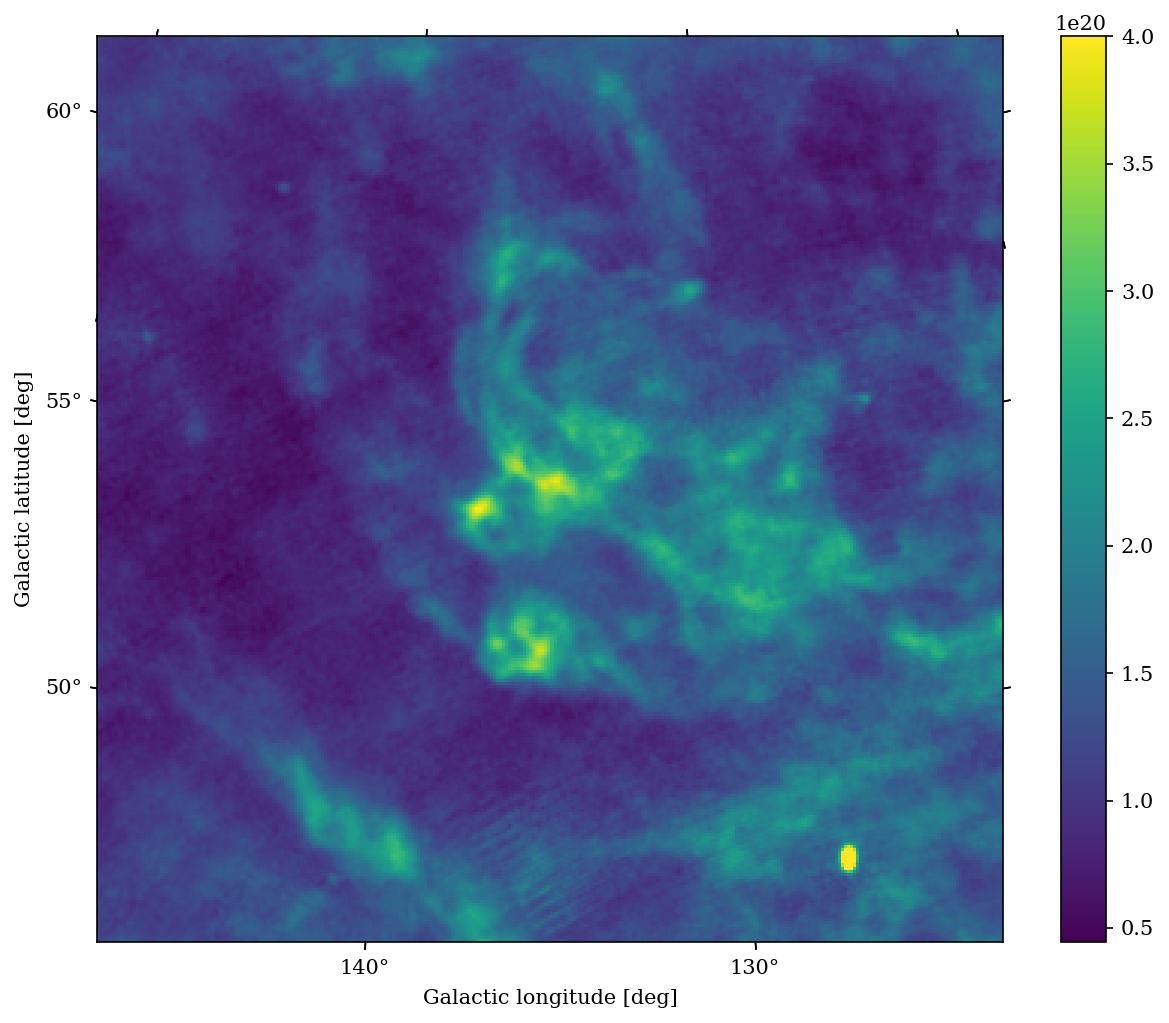

In [10]:
target_wcs = WCS(target_header)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(target_data, cmap='viridis', vmax=4.e20, **imkw)
plt.colorbar(im, ax=ax)
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

We start the gridding by initating the gridder with the `target_header`.

In [11]:
gridder = cygrid.WcsGrid(target_header)

To grid one image onto another, we need the coordinates for each pixel in the input image. To obtain these, we start by getting pixel coordinates with `np.meshgrid`.

In [12]:
input_lon_pix, input_lat_pix = np.meshgrid(
    np.arange(input_header['NAXIS1']),
    np.arange(input_header['NAXIS2'])
    )

Next, we convert these from pixel- to world-coordinates, using the `wcs` features from `astropy`.

In [13]:
input_lon_world, input_lat_world = input_wcs.all_pix2world(
    input_lon_pix, input_lat_pix, 0
    )

Lastly, we convert the coordinates from equatorial to galactic. This is really simple and straightforward as well.

In [14]:
coords_eq = SkyCoord(
    input_lon_world, input_lat_world, frame='icrs', unit='deg'
    )
coords_gal = coords_eq.galactic

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [15]:
kernelsize_fwhm = 2.5/60.
# see https://en.wikipedia.org/wiki/Full_width_at_half_maximum
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2))
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates and data.

In [16]:
gridder.grid(
    coords_gal.l.value.flatten(),
    coords_gal.b.value.flatten(),
    input_data.flatten(),
    )

To get the gridded map, we simply call `get_datacube()`.

In [17]:
datacube = gridder.get_datacube()

Here's how the gridded Planck field looks like, superposed with contours from the HI data onto which we gridded our Planck data.

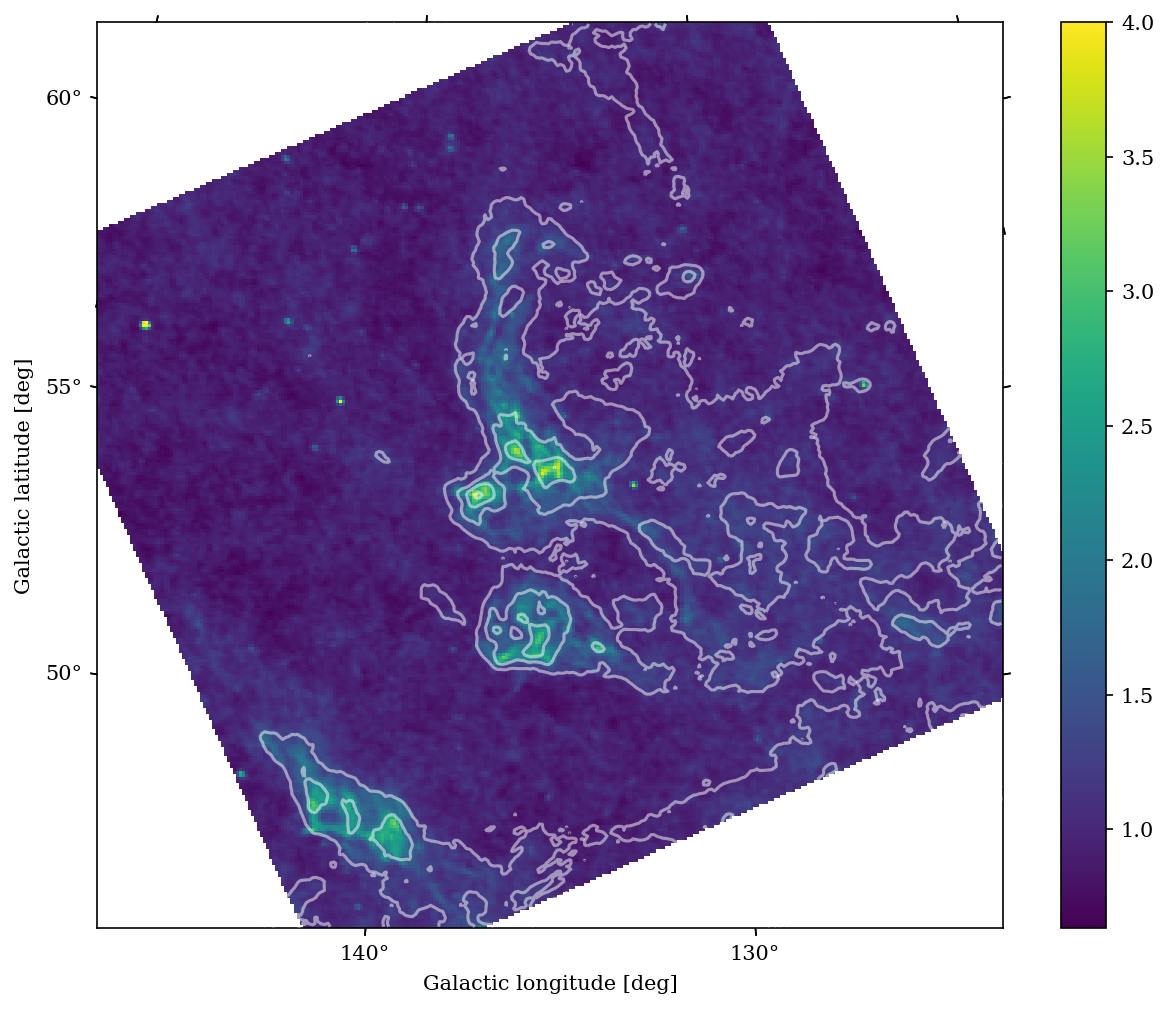

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(datacube, cmap='viridis', vmax=4., **imkw)
plt.colorbar(im, ax=ax)
ax.contour(
    target_data, colors='white',
    levels=np.arange(1.5e20, 1.e21, 8.e19), alpha=0.5
    )
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

Finally, we can write the fits-image to disk:

In [19]:
# fits.writeto(
#     'planck_to_ebhis.fits',
#     datacube,
#     target_wcs.celestial.to_header(),
#     )

Let's compare with the astropy reproject (affiliated) package. We'll need to construct a FITS image hdu to do this.

In [20]:
import reproject

In [21]:
input_hdu = fits.ImageHDU(data=input_data, header=input_header)

In [22]:
data_repr, footprint = reproject.reproject_interp(
    input_hdu, target_header, order='bicubic'
    )

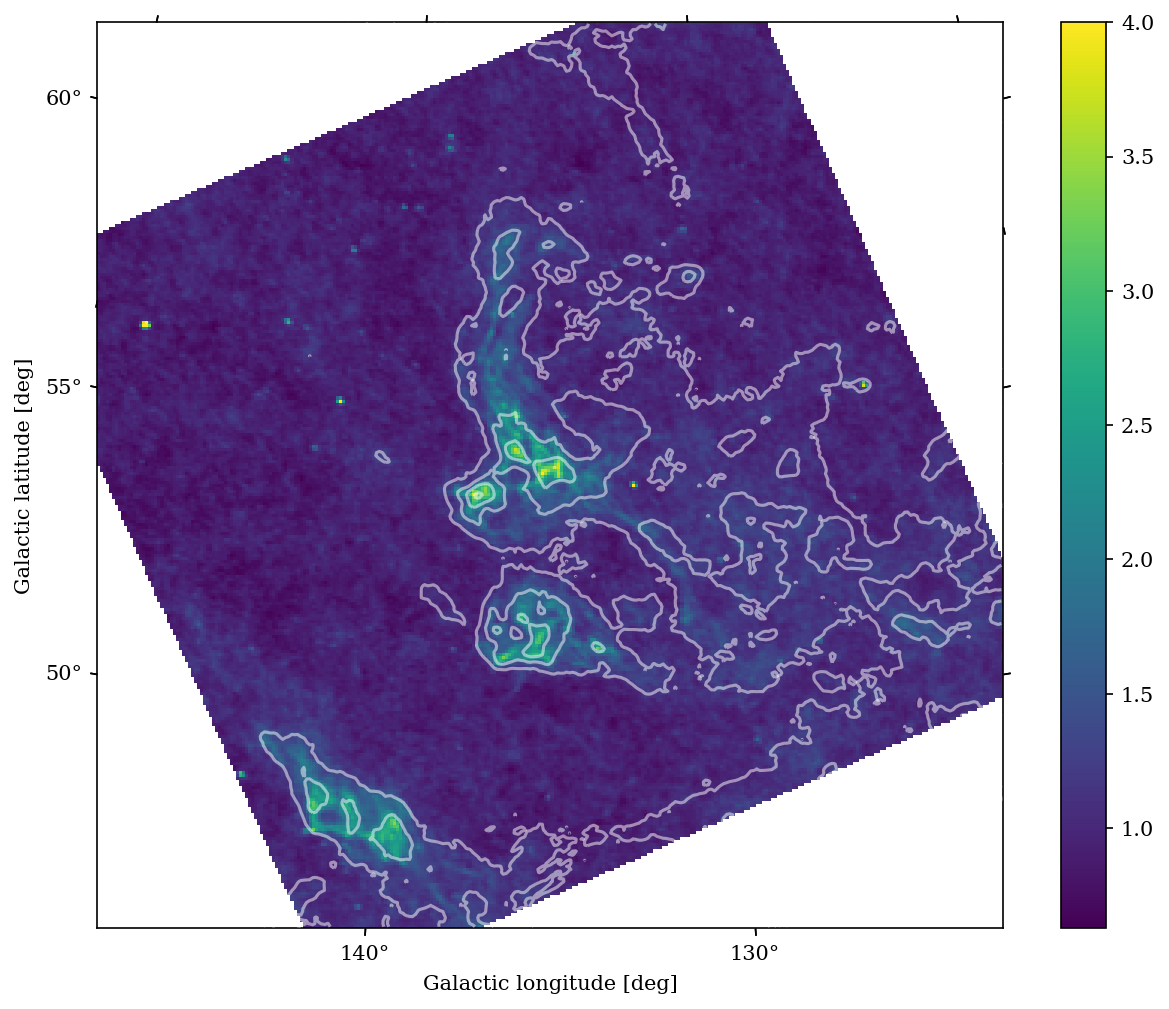

In [23]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(data_repr, cmap='viridis', vmax=4., **imkw)
plt.colorbar(im, ax=ax)
ax.contour(
    target_data, colors='white',
    levels=np.arange(1.5e20, 1.e21, 8.e19), alpha=0.5
    )
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

Which method is better? Cygrid will loose a little bit of spatial resolution (but better conserve flux, if sampling is high enough). It'll also work for very large images ($>10^8$) pixels, while reproject probably doesn't.

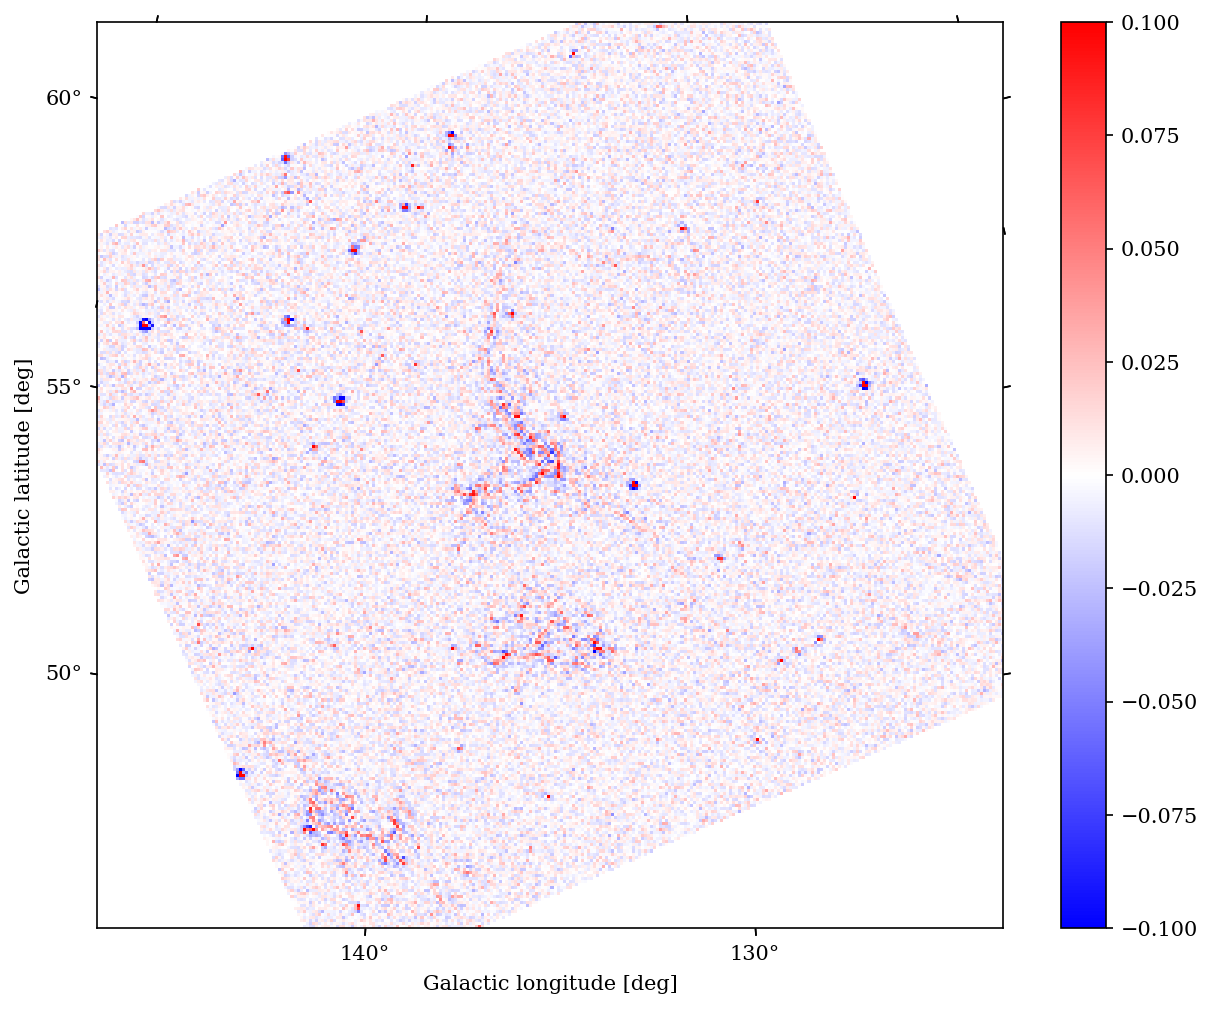

In [24]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(
    data_repr - datacube, cmap='bwr', vmin=-0.1, vmax=0.1, **imkw
    )
plt.colorbar(im, ax=ax)
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')